# AOS: integrating new repackager into ts_wep

** JIRA Tickets: **

   * https://jira.lsstcorp.org/browse/DM-26836 - IN PROGRESS - Adapt the Latest File Format of Corner WFS (main ticket requiring a new phosim repackager:  https://github.com/lsst-dm/phosim_utils/blob/master/python/lsst/phosim/utils/phosim_repackager.py ) 
   * https://jira.lsstcorp.org/browse/DM-28341 - IN PROGRESS - ingest phosim images into Butler with as-built camera geometry (illustrate that the new repackager works) 
   * https://jira.lsstcorp.org/browse/DM-28046 - IN PROGRESS - Update PhosimEimgParseTask to use LsstCam (needed for the repackager) 
   * https://jira.lsstcorp.org/browse/DM-28330 - IN PROGRESS - Update search pattern for amplifier images (needed for ts_wep to recognise new file format) 
   * https://jira.lsstcorp.org/browse/DM-27863 - DONE - Allow controller = 'H' for exposure_id calculation (needed for the repackager) 
    
 

To reproduce the data, the following was done:
    
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03
    
    # setup the stack and AOS packages
    source "/software/lsstsw/stack/loadLSST.bash"
    source /project/scichris/aos/setup_aos_current.sh


    # make sure we're using the branch with updates to ingest images,
    # using the correct mapper in policy/defaults.yaml
    
    cd /project/scichris/aos/ts_wep/
    git branch tickets/DM-28330
    setup -k -r .


    # do the same for  phosim_utils - 
    # use the ticket version of the repackager .. 
    
    cd /project/scichris/dev/phosim_utils/
    git branch tickets/DM-26836
    setup -k -r .

    # and for obs_lsst, ensure we're using 
    # the ticket version that
    # allows to ingest E-images with the new
    # parser ( I did not get a reply from Tim J. whether
    # my solution is fine or need a different one  - see 
    # my last comment  in the PR 
    # https://github.com/lsst/obs_lsst/pull/277 ) 

    cd /project/scichris/dev/obs_lsst_dev/
    git branch tickets/DM-28046
    setup -k -r .
    
    cd /project/scichris/aos/ts_phosim/
    python bin.src/imgCloseLoop.py --inst lsstfam --numOfProc 25 --boresightDeg 0.03 -0.02 --skyFile tests/testData/sky/skyLsstFam.txt --output /project/scichris/aos/results_lsstfam_noCrosstalk2/
    
    

A full log  of the terminal output is available at 

    /project/scichris/aos/results_lsstfam_noCrosstalk2/screenlog_lsstfam_noCrosstalk.txt : 


In [16]:
import numpy as np
from astropy.table import Table
filename = '/project/scichris/aos/results_lsstfam_noCrosstalk2/screenlog_lsstfam_noCrosstalk.txt'
with open(filename) as f:
    mylist = f.read().splitlines() 

The following lines show the last few calls to 1ingestCalibs.py1,  and the ISR (there is more but I show just a few rafts for illustration):
    

In [26]:
mylist[1630:1730]

['ingest INFO: /project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extra/MC_H_20211231_006001_R02_S11.fits --<link>--> /project/scichris/aos/results_lsstfam_noCrosstalk2/input/raw/2021-12-31/4021123106001/4021123106001-R02-S11-det013.fits',
 'ingest INFO: /project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extra/MC_H_20211231_006001_R31_S11.fits --<link>--> /project/scichris/aos/results_lsstfam_noCrosstalk2/input/raw/2021-12-31/4021123106001/4021123106001-R31-S11-det130.fits',
 'ingest INFO: /project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extra/MC_H_20211231_006001_R24_S11.fits --<link>--> /project/scichris/aos/results_lsstfam_noCrosstalk2/input/raw/2021-12-31/4021123106001/4021123106001-R24-S11-det112.fits',
 'ingest INFO: /project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extra/MC_H_20211231_006001_R10_S10.fits --<link>--> /project/scichris/aos/results_lsstfam_noCrosstalk2/input/raw/2021-12-31/4021123106001/4021123106001-R10-S10-det030.fits',


## Show the raw and the postISR images:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot = '/project/scichris/aos/results_lsstfam_noCrosstalk2/input/'
butler = dafPersist.Butler(dataRoot, )



In [3]:
dataId = dict(run='9006002', raftName='R01', detectorName='S11')
butler.datasetExists('raw', dataId)


True

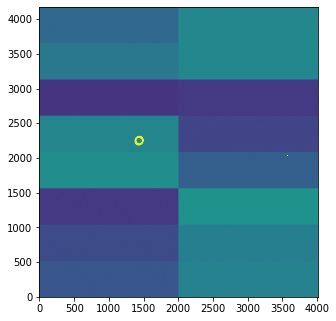

In [4]:
%matplotlib inline
post = butler.get('raw', dataId)
rawImage = post.image.array
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(rawImage.T, origin='lower',vmax=1100)

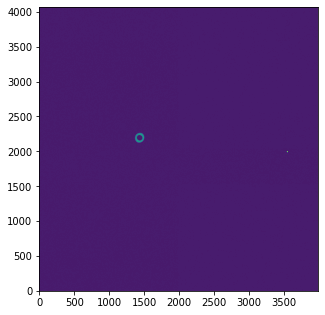

In [6]:
import os
repoRoot = os.path.join(dataRoot, 'rerun/run1')
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006002', visit=4021123106002, raftName='R01', detectorName='S11')
postISRimage = postISRbutler.get('postISRCCD', **dataId) 
ISR = post.image.array
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(postISRimage.T, origin='lower',vmax=500)


So it looks like for R01 S11 the ISR performed well, which I do not reconcile with the error message:

    'root INFO: Running: /software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/ip_isr/21.0.0-3-gd5de2f2+905c13b855/bin/runIsr.py /project/scichris/aos/results_lsstfam_noCrosstalk2/input --id --rerun=run1 --configfile /project/scichris/aos/results_lsstfam_noCrosstalk2/input/isr_config.py --no-versions',
     "runIsr.isr INFO: Performing ISR on sensor {'dayObs': '2021-12-31', 'expId': 4021123106002, 'raftName': 'R32', 'detectorName': 'S11', 'detector': 139}.",
     "obs.lsst.assembly WARN: DataId(initialdata={'dayObs': '2021-12-31', 'expId': 4021123106002, 'raftName': 'R32', 'detectorName': 'S11', 'detector': 139}, tag=set()): outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(521, 2009)))",
     'obs.lsst.assembly WARN: argDict[boresightAirmass] is None; stripping',
     "obs.lsst.assembly WARN: Unable to set WCS from header as RA/Dec/Angle are unavailable for dataId DataId(initialdata={'dayObs': '2021-12-31', 'expId': 4021123106002, 'raftName': 'R32', 'detectorName': 'S11', 'detector': 139}, tag=set())",
     'CameraMapper WARN: Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.',
     'CameraMapper WARN: Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.',
     'CameraMapper WARN: Multiple matches for filter FilterLabel(band="g") with data ID \'g\'.',
     'runIsr.isr INFO: Converting exposure to floating point values.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: ISR_OSCAN: No overscan region.  Not performing overscan correction.',
     'runIsr.isr INFO: Assembling CCD from amplifiers.',
     'runIsr.isr INFO: Masking NAN value pixels.',
     'runIsr.isr INFO: Widening saturation trails.',
     'runIsr.isr INFO: Applying flat correction.',
     "runIsr FATAL: Failed on dataId={'dayObs': '2021-12-31', 'expId': 4021123106002, 'raftName': 'R32', 'detectorName': 'S11', 'detector': 139}: RuntimeError: maskedImage bbox (minimum=(0, 0), maximum=(4095, 4003)) != flatMaskedImage bbox (minimum=(0, 0), maximum=(4071, 3999))",
     'Traceback (most recent call last):',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/pipe_base/21.0.0-6-gd3283ba+2605bebd58/python/lsst/pipe/base/cmdLineTask.py", line 431, in __call__',
     '    result = self.runTask(task, dataRef, kwargs)',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/pipe_base/21.0.0-6-gd3283ba+2605bebd58/python/lsst/pipe/base/cmdLineTask.py", line 495, in runTask',
     '    return task.runDataRef(dataRef, **kwargs)',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/ip_isr/21.0.0-3-gd5de2f2+905c13b855/python/lsst/ip/isr/isrTask.py", line 2621, in runDataRef',
     '    return self.isr.runDataRef(dataRef)',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/pipe_base/21.0.0-6-gd3283ba+2605bebd58/python/lsst/pipe/base/timer.py", line 157, in wrapper',
     '    res = func(self, *args, **keyArgs)',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/ip_isr/21.0.0-3-gd5de2f2+905c13b855/python/lsst/ip/isr/isrTask.py", line 1686, in runDataRef',
     '    result = self.run(ccdExposure, camera=camera, **isrData.getDict())',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/pipe_base/21.0.0-6-gd3283ba+2605bebd58/python/lsst/pipe/base/timer.py", line 157, in wrapper',
     '    res = func(self, *args, **keyArgs)',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/ip_isr/21.0.0-3-gd5de2f2+905c13b855/python/lsst/ip/isr/isrTask.py", line 1549, in run',
     '    self.flatCorrection(ccdExposure, flat)',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/ip_isr/21.0.0-3-gd5de2f2+905c13b855/python/lsst/ip/isr/isrTask.py", line 2159, in flatCorrection',
     '    isrFunctions.flatCorrection(',
     '  File "/software/lsstsw/stack_20210114/stack/miniconda3-py38_4.9.2-0.1.5/Linux64/ip_isr/21.0.0-3-gd5de2f2+905c13b855/python/lsst/ip/isr/isrFunctions.py", line 391, in flatCorrection',
     '    raise RuntimeError("maskedImage bbox %s != flatMaskedImage bbox %s" %',
     'RuntimeError: maskedImage bbox (minimum=(0, 0), maximum=(4095, 4003)) != flatMaskedImage bbox (minimum=(0, 0), maximum=(4071, 3999))',

The dimensions of each raft follow from phosimMapper https://github.com/lsst/obs_lsst/blob/master/policy/phosim/cameraHeader.yaml ,  which were injected into phosim_syseng4 in  https://github.com/lsst-ts/phosim_syseng4/blob/aos/data/lsst/segmentation.txt  and https://github.com/lsst-ts/phosim_syseng4/blob/aos/data/lsst/focalplanelayout.txt.  


The dimensions in LsstCamMapper are https://github.com/lsst/obs_lsst/blob/master/policy/cameraHeader.yaml 
(analogous file exists for PhosimMapper, but the dimensions of ITL/E2V are the same, the only difference are the saturation levels https://github.com/lsst/obs_lsst/blob/master/policy/phosim/cameraHeader.yaml

For instance, R32 S11 above, is ITL in phosimMapper https://github.com/lsst/obs_lsst/blob/master/policy/phosim/R32.yaml  and E2V in lsstCamMapper https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R32.yaml 

So the dimension mismatch is a result of all rafts being ITL in phosim, whereas in lsstCamMapper its a mixture of ITL and E2V.


A proposed solution is to "pad" the amplifier at the stage of repackaging, eg. using `np.pad` function. 

For instance, show the raw repackaged amplifier image:

In [1]:
import astropy.io.fits as fits
fname = '/project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extra/MC_H_20211231_006001_R32_S11.fits'
hdul = fits.open(fname)

In [2]:
#In the main header:
hdul[0].header['DETSIZE']

'[1:4096,1:4004]'

In [5]:
import numpy as np

In [9]:
array = hdul[1].data

In [10]:
#np.pad(array, )

In the amplifier header for C10 (hdul[1].header) the following is related to dimensionality:
    
    NAXIS1  =                  522                                                  
    NAXIS2  =                 2010 
    PIXX    =                 4000 / Chip x pixels                                  
    PIXY    =                 4072 / Chip y pixels                                  
    MINX    =                    0 / Minimum x pixel of amplifier                   
    MAXX    =                 3999 / Maximum x pixel of amplifier                   
    MINY    =                    0 / Minimum y pixel of amplifier                   
    MAXY    =                 4071 / Maximum y pixel of amplifier 
    PREAD   =                    1 / Parallel read out direction                    
    SREAD   =                    1 / Serial read out direction                      
    PSCANP  =                    3 / Pre-scan parallel                              
    OSCANS  =                    0 / Over-scan serial                               
    PSCANS  =                   10 / Pre-scan serial                                
    OSCANP  =                   10 / Over-scan parallel                                                                            
    RDORDER =                    1 / 0=CCS; 1=readorder                             
    RDNOISE =     2.30769230769231 / Readout noise (ADU/pixel)                      
    DRKCURR =                 0.02 / Dark Current (e-/pixel/s)                      
    TRIMSEC = '[   4: 512,   1:2000]' / Trimmed section of amplifier                
    DATASEC = '[11:522,1:2002]'    / Data section of amplifier                      
    EXTNAME = 'Segment10'                                                           
    DETSEC  = '[512:1,4004:2003]'               



I'm not sure how to reconcile the raw amplifier dimensionality with the information in the mapper:

In [54]:
for i in range(1,len(hdul)):
    print(hdul[i].header['AMPID'],np.shape(hdul[i].data))

C10 (2010, 522)
C11 (2010, 522)
C12 (2010, 522)
C13 (2010, 522)
C14 (2010, 522)
C15 (2010, 522)
C16 (2010, 522)
C17 (2010, 522)
C07 (2010, 522)
C06 (2010, 522)
C05 (2010, 522)
C04 (2010, 522)
C03 (2010, 522)
C02 (2010, 522)
C01 (2010, 522)
C00 (2010, 522)


`focalplanelayout.txt` suggests that each of the main rafts is 4000 x 4072 px. The `segmentation.txt` for R32 S11 for amp C00 has 

    R32_S11_C00 0 1999 0 508 1 -1 1.695 0 1000.0 2.0 4.12 0 0.02 0.0 3 0 10 10
    
    # (1): amplifier name
    # (2-5): x low, x high, y low, y high
    # (6): serialread
    # (7): parallelread
    # (8-9): gain, % variation
    # (10-11): bias level, % variation
    # (12-13): readnoise , % variation
    # (14-15): dark current, % variation
    # (16-19): parallel prescan, serial overscan, serial prescan, parallel overscan (pixel)
    
    i.e.
    x low, x high, y low, y high = 0, 1999, 0, 508
    parallel prescan, serial overscan, serial prescan, parallel overscan (pixel) = 
    3, 0, 10, 10
    
 So the amp dimensions in phosim come from 
 
 2000 (x_high-x_low incl. 0) + 10 (serial prescan) + 0 (serial overscan) = 2010 
 
 509 (y_high-y_low incl. 0) + 3 (parallel prescan) + 10 (parallel overscan) = 522
 
 

Check what this raft should be ( `CCD_MANU` is encoded from `detectors.getSerial()` during the repackaging stage:

In [11]:
hdul[0].header['CCD_MANU']

'E2V'

In [12]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
EXPTIME =                 15.0                                                  
DARKTIME=                 15.0                                                  
RUNNUM  = '9006001 '                                                            
MJD-OBS =     59579.9999131944                                                  
DATE-OBS= '2021-12-31T23:59:52.500'                                             
DAYOBS  = '20211231'                                                            
DATE    = '2021-01-20T21:16:34'                                                 
MJD     =    59234.88650462963                                                  
FILTER  = 'g       '        

In [1]:
from lsst.obs.lsst import LsstCam
sensorId = 'R32_S11'
camera = LsstCam().getCamera()
detectors = camera.get(sensorId)
detectors.getBBox()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(4096, 4004))

In [2]:
detectors.getSerial()

'E2V-CCD250-386'

In [3]:
amp = detectors.getAmplifiers()[0]


In [4]:
amp.getBBox()

Box2I(minimum=Point2I(0, 2002), dimensions=Extent2I(512, 2002))

In [7]:
amp.getRawDataBBox()

Box2I(minimum=Point2I(10, 0), dimensions=Extent2I(512, 2002))

In [5]:
amp.getRawHorizontalOverscanBBox()

Box2I(minimum=Point2I(522, 0), dimensions=Extent2I(54, 2002))

In [6]:
amp.getRawHorizontalPrescanBBox()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(10, 2002))

In [ ]:
from lsst.obs.lsst import phosim
sensorId = 'R32_S11'
camera = LsstCam().getCamera()
detectors = camera.get(sensorId)
detectors.getBBox()

In [43]:
# required dimensions
dims = amp.getRawBBox().getDimensions()
long = max(dims)
short = min(dims)

In [50]:
print(long,short)

2048 576


In [ ]:
E2V dimensions are [2048x576]. This is also stored for each amp in `amp.getRawBBox()` 
 


In [22]:
arr = hdul[1].data

In [25]:
arr.shape

(2010, 522)

In [49]:
d1, d2 = np.shape(arr)
print(d1,d2 )

2010 522


2010

In [86]:
# need to assert that
# the desired dimensions stored in lsstCamMapper
# are larger than the current ones 
diffLong = long-d1
diffShort = short-d2

# this works 
addBeforeLong = diffLong // 2
addAfterLong = diffLong - addBeforeLong
print(addBeforeLong, addAfterLong)


addBeforeShort = diffShort // 2
addAfterShort = diffShort - addBeforeShort
print(addBeforeShort, addAfterShort)


arrPad = np.pad(arr, ((addBeforeLong, addAfterLong),(addBeforeShort, addAfterShort)),
                mode='constant', constant_values = np.nan )

19 19
27 27


In [87]:
arrPad

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [79]:
# validate that the new shape is the expected one 
newDim = np.shape(arrPad)
newLong, newShort = max(newDim), min(newDim)

#print(newLong, long)
#print(newShort, short)

assert newLong == long
assert newShort == short 

Show the padded array to prove that it worked:

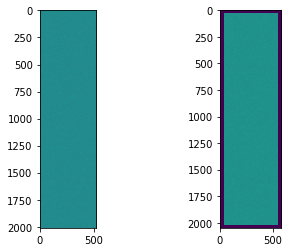

In [85]:
import matplotlib.pyplot as plt 
fig,ax = plt.subplots(1,2)
ax[0].imshow(arr)
ax[1].imshow(arrPad,vmin=1000)

In [1]:
diffLong // 2.

NameError: name 'diffLong' is not defined

Need to add the following in `repackage_corner()` and `repackage_main()`, at each stage when going through the amplifiers:

In [93]:
np.shape(hdul[1].data)

(2048, 576)

In [98]:
import astropy.io.fits as fits
fname = '/project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extra/MC_H_20211231_006001_R32_S11.fits'
hdul = fits.open(fname)

In [99]:
for i in range(1,len(hdul)):
    hdu = hdul[i]

    # 1. pull required dimensions from LsstCamMapper 
    mapperDims = amp.getRawBBox().getDimensions()
    longMapperDim, shortMapperDim = max(mapperDims), min(mapperDims)

    # 2. check the current dimensions of the phosim data 
    data = np.copy(hdu.data)
    dataDims = np.shape(data)
    longDataDim, shortDataDim = max(dataDims), min(dataDims)


    # 3. need to assert that
    # the desired dimensions stored in lsstCamMapper
    # are larger than the current ones 
    assert longMapperDim > longDataDim
    assert shortMapperDim > shortDataDim
    diffLong = longMapperDim - longDataDim
    diffShort = shortMapperDim - shortDataDim

    # Find out the amount of padding on each 
    # side of the array for the long and the short
    # dimension 
    addLongBefore = diffLong // 2
    addLongAfter = diffLong - addLongBefore
    #print(addLongBefore, addLongAfter)


    addShortBefore = diffShort // 2
    addShortAfter = diffShort - addShortBefore
    #print(addShortBefore, addShortAfter)


    dataPadded = np.pad(data, ((addLongBefore, addLongAfter),(addShortBefore, addShortAfter)),
                    mode='constant', constant_values = np.nan )

    # validate that the new shape is the expected one 
    dataNewDim = np.shape(dataPadded)
    longNewDim, shortNewDim = max(dataNewDim), min(dataNewDim)

    assert longNewDim == longMapperDim
    assert shortNewDim == shortMapperDim

    hdu.data = dataPadded 

    hdul[i] = hdu
    
    


19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27
19 19
27 27


In [ ]:
cgUu

In [101]:
import os
filename = 'MC_H_20211231_006001_R32_S11.fits'
out_dir = '/project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extraPad/'
filename = os.path.join(out_dir, filename)
hdul.writeto(filename, overwrite=True)

In [91]:
np.shape(hdu.data)

(2048, 576)

try ingesting that data:


    cd /project/scichris/aos/results_lsstfam_noCrosstalk2
    mkdir input2

    cd fake_flats
    makeGainImages.py --detector_list  R32_S11  


    ingestCalibs.py /project/scichris/aos/results_lsstfam_noCrosstalk2/input2/ /project/scichris/aos/results_lsstfam_noCrosstalk2/fake_flats/* --validity 99999 --output /project/scichris/aos/results_lsstfam_noCrosstalk2/input2/
    
    
    ingestImages.py /project/scichris/aos/results_lsstfam_noCrosstalk2/input2/ /project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extraPad/*.fits
    
    runIsr.py  /project/scichris/aos/results_lsstfam_noCrosstalk2/input2/   --id  --rerun=run1  --configfile /project/scichris/aos/results_lsstfam_noCrosstalk2/input2/isr_config.py  --no-versions
    

I get an error :
    
    runIsr.isr INFO: Applying flat correction.
    runIsr FATAL: Failed on dataId={'dayObs': '2021-12-31', 'expId': 4021123106001, 'raftName': 'R32', 'detectorName': 'S11', 'detector': 139}: RuntimeError: maskedImage bbox (minimum=(0, 0), maximum=(4095, 4003)) != flatMaskedImage bbox (minimum=(0, 0), maximum=(4071, 3999))
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-6-gd3283ba+8abc1306da/python/lsst/pipe/base/cmdLineTask.py", line 431, in __call__
        result = self.runTask(task, dataRef, kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-6-gd3283ba+8abc1306da/python/lsst/pipe/base/cmdLineTask.py", line 495, in runTask
        return task.runDataRef(dataRef, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+1410490d4b/python/lsst/ip/isr/isrTask.py", line 2621, in runDataRef
        return self.isr.runDataRef(dataRef)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-6-gd3283ba+8abc1306da/python/lsst/pipe/base/timer.py", line 157, in wrapper
        res = func(self, *args, **keyArgs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+1410490d4b/python/lsst/ip/isr/isrTask.py", line 1686, in runDataRef
        result = self.run(ccdExposure, camera=camera, **isrData.getDict())
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/pipe_base/21.0.0-6-gd3283ba+8abc1306da/python/lsst/pipe/base/timer.py", line 157, in wrapper
        res = func(self, *args, **keyArgs)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+1410490d4b/python/lsst/ip/isr/isrTask.py", line 1549, in run
        self.flatCorrection(ccdExposure, flat)
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+1410490d4b/python/lsst/ip/isr/isrTask.py", line 2165, in flatCorrection
        trimToFit=self.config.doTrimToMatchCalib
      File "/opt/lsst/software/stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/ip_isr/21.0.0-1-g763706f+1410490d4b/python/lsst/ip/isr/isrFunctions.py", line 392, in flatCorrection
        (maskedImage.getBBox(afwImage.LOCAL), flatMaskedImage.getBBox(afwImage.LOCAL)))
    RuntimeError: maskedImage bbox (minimum=(0, 0), maximum=(4095, 4003)) != flatMaskedImage bbox (minimum=(0, 0), maximum=(4071, 3999))
    
    
    

This must be because flats have a wrong dimension compared to LsstCamMapper - they have a dimension from PhosimMapper...

Need to change that in `makeGainImages.py` : 

In [16]:
from datetime import datetime
import argparse

from lsst.obs.lsst import LsstCam
from lsst.obs.lsst.phosim import PhosimMapper
import lsst.afw.image as afwImage
import numpy as np
import os 

In [19]:
def makeGainImages(just_wfs=False, detector_list=None, out_dir='.'):

    if (just_wfs is True) and (detector_list is not None):
        raise RuntimeError("--just_wfs and --detector_list are exclusive.")

    cameraLsst = LsstCam().getCamera()
    cameraPhosim = PhosimMapper().camera
    if just_wfs:
        raise RuntimeError(" can't do corner sensors yet with hybrid phosim and lsstCam mappers")
        #ccd_list = [camera[name] for name in ["R00_S22", "R04_S20", "R44_S00", "R40_S02"]]
    elif (detector_list is not None):
        ccd_list_lsst = [cameraLsst[name] for name in detector_list]
        ccd_list_phosim = [cameraPhosim[name] for name in detector_list]
    else:
        ccd_list_lsst = cameraLsst
        ccd_list_phosim = cameraPhosim
    
    for filt_name in 'ugrizy':
        for ccdLsst, ccdPhosim in zip(ccd_list_lsst, ccd_list_phosim):
            name = ccdLsst.getName()
            # I'm not sure how to deal with the split chips yet.
            if 'A' in name or 'B' in name:
                continue
            print(name)
            CHIPID = "".join([c for c in name if c != "," and c != ":"])
            CHIPID = "_".join(CHIPID.split())
            
            # get dimension from LsstCamMapper 
            image = afwImage.ImageF(ccdLsst.getBBox())
            for ampLsst, ampPhosim in zip(ccdLsst, ccdPhosim):
                subim = afwImage.ImageF(image, ampLsst.getBBox())
                subim[:] = 1/ampPhosim.getGain()
                print('%s phosimMapper %s , %2.3f/ lsstCamMapper %s ,%2.3f'%
                      (filt_name, ampPhosim.getName(), ampPhosim.getGain(), ampLsst.getName(), 
                       ampLsst.getGain())
                     )

            # need to flip the image to match the result of phosim repackager...
            oldImageArray = image.array.copy()
            image.array[:] = np.flipud(oldImageArray)

            expInfo = afwImage.ExposureInfo()
            inFilter = afwImage.Filter(filt_name)
            expInfo.setFilter(inFilter)
            exp = afwImage.ExposureF(afwImage.MaskedImageF(image), expInfo)
            md = exp.getMetadata()
            md.set('CHIPID', CHIPID)
            # Set place holder date
            md.set('MJD-OBS', 53005.0)
            md.set('OBSTYPE', 'flat')
            # arbitrary for flats
            md.set('EXPTIME', 100)
            # need to be able to specify any filter
            md.set('CALDATE', 53005.0)
            # Add the CALIB_ID header card
            md.set('CALIB_ID', 'raftName=%s detectorName=%s detector=%i filter=%s calibDate=%s' %
                   (CHIPID.split('_')[0], CHIPID.split('_')[1], 
                    ccdPhosim.getId(), filt_name, datetime.now()))
            exp.setMetadata(md)
            filename = "%(name)s_%(filter)s.fits"%({'name': CHIPID, 'filter': filt_name})
            filename = os.path.join(out_dir, filename)
            exp.writeFits(filename)


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description='Make fake flats using image gains')
#     parser.add_argument('--just_wfs', action='store_true',
#                         help='Generate fake flats for just wavefront sensing chips.')
#     parser.add_argument('--detector_list', nargs='+',
#                         help='Generate fake flats for the detector list. (e.g. R22_S11 R22_S10)')

#     args = parser.parse_args()
#     main(just_wfs=args.just_wfs, detector_list=args.detector_list)


In [20]:
makeGainImages(detector_list=['R32_S11'], 
               out_dir='/project/scichris/aos/results_lsstfam_noCrosstalk2/fake_flats/')

R32_S11
u phosimMapper C10 , 1.742/ lsstCamMapper C10 ,1.001
u phosimMapper C11 , 1.774/ lsstCamMapper C11 ,37.962
u phosimMapper C12 , 1.750/ lsstCamMapper C12 ,23.563
u phosimMapper C13 , 1.663/ lsstCamMapper C13 ,15.516
u phosimMapper C14 , 1.662/ lsstCamMapper C14 ,17.442
u phosimMapper C15 , 1.670/ lsstCamMapper C15 ,15.966
u phosimMapper C16 , 1.783/ lsstCamMapper C16 ,19.340
u phosimMapper C17 , 1.657/ lsstCamMapper C17 ,1.061
u phosimMapper C07 , 1.696/ lsstCamMapper C07 ,1.073
u phosimMapper C06 , 1.772/ lsstCamMapper C06 ,18.501
u phosimMapper C05 , 1.701/ lsstCamMapper C05 ,13.294
u phosimMapper C04 , 1.638/ lsstCamMapper C04 ,1.078
u phosimMapper C03 , 1.731/ lsstCamMapper C03 ,1.088
u phosimMapper C02 , 1.657/ lsstCamMapper C02 ,19.887
u phosimMapper C01 , 1.734/ lsstCamMapper C01 ,17.631
u phosimMapper C00 , 1.695/ lsstCamMapper C00 ,19.187
R32_S11
g phosimMapper C10 , 1.742/ lsstCamMapper C10 ,1.001
g phosimMapper C11 , 1.774/ lsstCamMapper C11 ,37.962
g phosimMapper C12

Ingest the raws, calibs,  and try to run the ISR again, in a clean dir : m

    ingestCalibs.py /project/scichris/aos/results_lsstfam_noCrosstalk2/input3/ /project/scichris/aos/results_lsstfam_noCrosstalk2/fake_flats/* --validity 99999 --output /project/scichris/aos/results_lsstfam_noCrosstalk2/input3/


    ingestImages.py /project/scichris/aos/results_lsstfam_noCrosstalk2/input3/ /project/scichris/aos/results_lsstfam_noCrosstalk2/iter0/img/extraPad/*.fits

    runIsr.py  /project/scichris/aos/results_lsstfam_noCrosstalk2/input3/   --id  --rerun=run1  --configfile /project/scichris/aos/results_lsstfam_noCrosstalk2/input3/isr_config.py  --no-versions

Did not fail : display the results : 

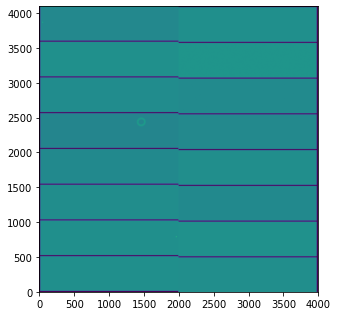

In [37]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
dataRoot='/project/scichris/aos/results_lsstfam_noCrosstalk2/input3/'
repoRoot = os.path.join(dataRoot, 'rerun/run1') 
postISRbutler = dafPersist.Butler(repoRoot, )
dataId = dict(run='9006001', visit=4021123106001, raftName='R32', detectorName='S11')
post = postISRbutler.get('postISRCCD', **dataId) 
image = post.image.array


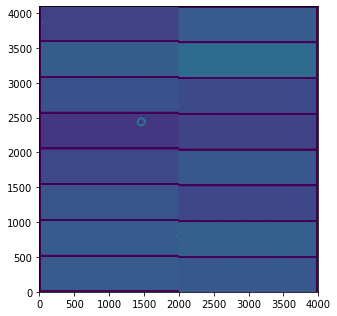

In [48]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(image.T, origin='lower',vmin=1400,vmax=2600)


#detector_list = ['R22_S22'

camera = LsstCam().getCamera()
detectors = camera['R22_S22']
for amp in detectors:
    print('phosimMapper %s , %2.3f/ lsstCamMapper %s , %2.3f '%(amp.getName(),amp.getGain()))

In [13]:
ccdLsst = detectors
ccdLsst.getId()

98

In [119]:
from lsst.obs.lsst import LsstCam
from lsst.obs.lsst.phosim import PhosimMapper

cameraLsst = LsstCam().getCamera()
cameraPhosim = PhosimMapper().camera

detector_list = ['R22_S00', 'R22_S01']
ccd_list_lsst = [cameraLsst[name] for name in detector_list]
ccd_list_phosim = [cameraPhosim[name] for name in detector_list]

for ccdLsst, ccdPhosim in zip(ccd_list_lsst, ccd_list_phosim):
    name = ccdLsst.getName()
#     name2 = ccdPhosim.getName()
#     print(name, name2)
    for ampLsst, ampPhosim in zip(ccdLsst, ccdPhosim):
        print(ampLsst.getName(), ampPhosim.getName(),\
             ampLsst.getGain(), ampPhosim.getGain())

C10 C10 1.11574 1.719
C11 C11 1.12172 1.716
C12 C12 1.12397 1.653
C13 C13 1.11068 1.78
C14 C14 1.10262 1.735
C15 C15 1.09866 1.678
C16 C16 1.09953 1.678
C17 C17 1.0998 1.732
C07 C07 1.134 1.705
C06 C06 1.14198 1.671
C05 C05 1.14213 1.764
C04 C04 1.13505 1.606
C03 C03 1.14424 1.622
C02 C02 1.1477 1.729
C01 C01 1.14254 1.641
C00 C00 1.15042 1.706
C10 C10 1.09494 1.718
C11 C11 1.09536 1.646
C12 C12 1.10077 1.766
C13 C13 1.1047 1.786
C14 C14 1.10545 1.66
C15 C15 1.09523 1.669
C16 C16 1.10021 1.801
C17 C17 1.10691 1.638
C07 C07 1.10797 1.613
C06 C06 1.10142 1.704
C05 C05 1.09929 1.763
C04 C04 1.0997 1.583
C03 C03 1.09774 1.727
C02 C02 1.09992 1.734
C01 C01 1.09693 1.69
C00 C00 1.10505 1.687


In [102]:
camera = LsstCam().getCamera()

In [105]:
for ccd in camera['R22_S22']:
    print(ccd.getName())

C10
C11
C12
C13
C14
C15
C16
C17
C07
C06
C05
C04
C03
C02
C01
C00
